In [10]:
import os
import json
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Configuration ---
GROUP_NAME = "meat"
BASE_DIR = "data/classification_data"

# Paths
DATA_GROUP_DIR = os.path.join(BASE_DIR, GROUP_NAME)
IMAGES_DIR = os.path.join(DATA_GROUP_DIR, "images")
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, "train")
VAL_IMAGES_DIR = os.path.join(IMAGES_DIR, "val")
TRAIN_LABELS_PATH = os.path.join(DATA_GROUP_DIR, f"{GROUP_NAME}_labels_train.csv")
VAL_LABELS_PATH = os.path.join(DATA_GROUP_DIR, f"{GROUP_NAME}_labels_val.csv")
CLASS_MAPPING_PATH = "pipeline_data/dicts/classification_groups.json"

In [11]:
class CustomFoodDataset(Dataset):
    """
    A custom PyTorch Dataset to load images from a directory and labels from a CSV file.
    """
    def __init__(self, csv_file, img_dir, group_name, class_map_path, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image names and class IDs.
            img_dir (str): Directory with all the images.
            group_name (str): The specific food group (e.g., 'meat').
            class_map_path (str): Path to the JSON file with all class mappings.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # Load the class mapping
        with open(class_map_path, 'r') as f:
            class_groups = json.load(f)
        
        # Get the class names for the specific group and convert class_id to integer
        self.class_mapping = class_groups[group_name]
        self.labels_df['class_id'] = self.labels_df['class_id'].astype(int)
        
        # Determine number of classes
        self.num_classes = len(self.class_mapping)

    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx): 
        ## Get image path 
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        ## Get label
        label = self.labels_df.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        ## Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


## Helper functions for visualizations

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- Denormalization Function ---
def denormalize(tensor):
    """Denormalize a tensor image for visualization."""

    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    denorm_tensor = tensor.clone().cpu().numpy()
    
    denorm_tensor = denorm_tensor.transpose((1, 2, 0)) 
    
    denorm_tensor = denorm_tensor * STD + MEAN
    
    denorm_tensor = np.clip(denorm_tensor, 0, 1)
    
    return denorm_tensor

def get_class_name(label_id, group_name, class_map_path="pipeline_data/dicts/classification_groups.json"):
    """Maps a class ID back to its string name."""
    import json
    with open(class_map_path, 'r') as f:
        class_groups = json.load(f)
    
    return class_groups[group_name].get(str(label_id.item()), "Unknown Class")

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),   # Data augmentation
    transforms.ToTensor(),               # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = CustomFoodDataset(
    csv_file=TRAIN_LABELS_PATH, 
    img_dir=TRAIN_IMAGES_DIR, 
    group_name=GROUP_NAME, 
    class_map_path=CLASS_MAPPING_PATH,
    transform=train_transforms
)

val_dataset = CustomFoodDataset(
    csv_file=VAL_LABELS_PATH, 
    img_dir=VAL_IMAGES_DIR, 
    group_name=GROUP_NAME, 
    class_map_path=CLASS_MAPPING_PATH,
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

NUM_CLASSES = train_dataset.num_classes
print(f"Number of classes for '{GROUP_NAME}': {NUM_CLASSES}")

Number of classes for 'meat': 11


Label ID: 1, Class Name: beef


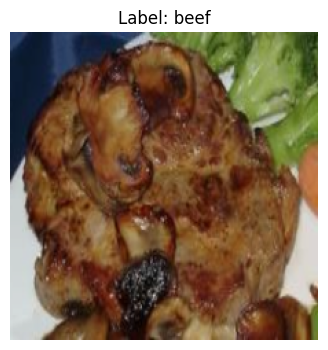

In [15]:
## visualize a sample image with label
import matplotlib.pyplot as plt
image, label = train_dataset[0]
denorm_image = denormalize(image)
class_name = get_class_name(label, GROUP_NAME)
print(f"Label ID: {label.item()}, Class Name: {class_name}")
plt.figure(figsize=(4,4))
plt.imshow(denorm_image)
plt.title(f"Label: {class_name}")
plt.axis('off') 
plt.show()

In [16]:
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomCNN, self).__init__()
        
        # --- Feature Extraction Layers ---
        # Input image size: 3 x 224 x 224 (RGB)
        
        # 1. Convolutional Layer 1
        # 3 input channels (RGB), 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output size after conv1 & pool: 16 x 112 x 112
        
        # 2. Convolutional Layer 2
        # 16 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Output size after conv2 & pool: 32 x 56 x 56
        
        # 3. Convolutional Layer 3
        # 32 input channels, 64 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Output size after conv3 & pool: 64 x 28 x 28
        
        # --- Classification Layers (Fully Connected) ---
        # The feature map size entering the FC layer is 64 channels * 28*28 pixels
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # 1. Feature Extraction
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # 2. Flatten (prepare for fully connected layers)
        # x.size(0) is the batch size
        x = x.view(-1, 64 * 28 * 28) 
        
        # 3. Classification
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output logits for CrossEntropyLoss
        
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Instantiate the New Model ---
model = CustomCNN(num_classes=NUM_CLASSES)
model.to(device) # Move model to the GPU if 'device' is cuda:0

# --- Re-define Optimizer ---
# Since this is a new model, we optimize ALL parameters, not just the last layer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(f"Instantiated CustomCNN with {NUM_CLASSES} output classes.")
# print(model) # Uncomment to see the layer structure

Instantiated CustomCNN with 11 output classes.


In [17]:
import torch
# Use the notebook version of tqdm for better display in Jupyter
from tqdm.notebook import tqdm 
import torch.nn as nn # Ensure you have all necessary imports

def train_model(model, train_loader, val_loader, criterion, optimizer,
                        num_epochs=10, device=None,
                        save_model=False, save_folder="classification_models"):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Move model to device again, just in case
    model.to(device) 
    
    print(f"--- Starting Notebook Enhanced Training on {device} ---")
    
    # Outer loop for epochs
    for epoch in tqdm(range(num_epochs), desc="Overall Training Progress", leave=True):
        
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        
        # Inner loop for batches: WRAP DataLoader with enumerate()
        # Use tqdm.notebook.tqdm here as well
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} (Train)", leave=False)
        for i, (inputs, labels) in train_bar: 
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            # Update the progress bar with current batch loss (RECOMMENDED display)
            train_bar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})
            
            # Note: We will NOT use tqdm.write for batch-level printing here 
            # to keep the notebook output clean, relying on set_postfix instead.

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        # Inner loop for batches
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)", leave=False)
        with torch.no_grad(): 
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_predictions / total_samples

        # Print the final epoch summary
        print(f'✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')

    print("\n--- Training Complete ---")
    
    # --- Model Saving Logic ---
    if save_model:
        # 1. Create directory if it doesn't exist
        os.makedirs(save_folder, exist_ok=True)
        
        # 2. Define filename using GROUP_NAME (or a fallback)
        try:
            model_filename = f'{GROUP_NAME}_customcnn.pth'
        except NameError:
            model_filename = 'final_model_customcnn.pth'
            
        full_path = os.path.join(save_folder, model_filename)
        
        # 3. Save the model's state dictionary
        torch.save(model.state_dict(), full_path)
        print(f"Model successfully saved to: {full_path}")
    else:
        print("Model saving skipped (save_model=False).")

# --- Execution ---
# Now, call this function with your variables
train_model(model, train_loader, val_loader, criterion, optimizer,
            num_epochs=10, device=device, save_model=True, save_folder="classification_models")

--- Starting Notebook Enhanced Training on cuda ---


Overall Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 1 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 1/10: Train Loss: 2.0656 | Val Loss: 1.8502 | Val Acc: 0.3429


Epoch 2 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 2/10: Train Loss: 1.5732 | Val Loss: 1.6172 | Val Acc: 0.4269


Epoch 3 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 3/10: Train Loss: 1.1291 | Val Loss: 1.5622 | Val Acc: 0.5264


Epoch 4 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 4/10: Train Loss: 0.7224 | Val Loss: 1.3872 | Val Acc: 0.5815


Epoch 5 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 5/10: Train Loss: 0.3977 | Val Loss: 1.4885 | Val Acc: 0.5935


Epoch 6 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 6/10: Train Loss: 0.2560 | Val Loss: 1.5943 | Val Acc: 0.6115


Epoch 7 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 7/10: Train Loss: 0.1509 | Val Loss: 1.6590 | Val Acc: 0.6151


Epoch 8 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 8/10: Train Loss: 0.1226 | Val Loss: 1.9528 | Val Acc: 0.6067


Epoch 9 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 9/10: Train Loss: 0.0767 | Val Loss: 2.5278 | Val Acc: 0.6115


Epoch 10 (Train):   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 10 (Val):   0%|          | 0/53 [00:00<?, ?it/s]

✅ Epoch 10/10: Train Loss: 0.0375 | Val Loss: 2.6415 | Val Acc: 0.6127

--- Training Complete ---
Model successfully saved to: classification_models\meat_customcnn.pth


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# --- Assuming the following variables are defined from previous steps: ---
# model (the CustomCNN instance, loaded or ready)
# val_dataset (the CustomFoodDataset instance for validation)
# GROUP_NAME
# CLASS_MAPPING_PATH
# device (e.g., torch.device("cuda:0"))

# --- Helper Functions from earlier steps (required for plotting) ---

# Mean and Std Dev used for normalization during training
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """Denormalize a tensor image for visualization."""
    denorm_tensor = tensor.clone().cpu().numpy()
    denorm_tensor = denorm_tensor.transpose((1, 2, 0)) # (C, H, W) -> (H, W, C)
    denorm_tensor = denorm_tensor * STD + MEAN
    denorm_tensor = np.clip(denorm_tensor, 0, 1)
    return denorm_tensor

def get_class_name(label_id, group_name, class_map_path=CLASS_MAPPING_PATH):
    """Maps a class ID back to its string name."""
    import json
    with open(class_map_path, 'r') as f:
        class_groups = json.load(f)
    
    # Class IDs in JSON are strings, so convert the label_id (int) to string
    return class_groups[group_name].get(str(label_id), "Unknown Class")

# --- Main Inference & Plotting Logic ---

def visualize_inference_grid(model, dataset, num_samples=9, group_name=GROUP_NAME, device=device):
    """
    Selects random samples, runs inference, and plots the results in a grid.
    
    Args:
        model: The trained PyTorch model.
        dataset: The validation or test dataset.
        num_samples (int): Number of images to display (should be a perfect square like 9, 16, etc.).
        group_name (str): The food group name ('meat').
        device: The device to run inference on.
    """
    model.eval() # Set model to evaluation mode
    
    # 1. Select random indices
    if num_samples > len(dataset):
        num_samples = len(dataset)
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    # 2. Setup plot grid
    cols = int(np.sqrt(num_samples))
    rows = int(np.ceil(num_samples / cols))
    
    plt.figure(figsize=(4 * cols, 4 * rows))
    
    # 3. Process and Plot Samples
    for i, idx in enumerate(indices):
        # Get data and true label
        image_tensor, true_label_id = dataset[idx]
        true_class_name = get_class_name(true_label_id.item(), group_name)
        
        # Run inference
        with torch.no_grad():
            # Add batch dimension (1, C, H, W) and move to device
            input_tensor = image_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)
            
            # Convert logits to probabilities and get the predicted class index
            probabilities = F.softmax(output, dim=1)
            pred_label_id = torch.argmax(probabilities, dim=1).item()
            pred_class_name = get_class_name(pred_label_id, group_name)

        # Determine color for title
        is_correct = (pred_label_id == true_label_id.item())
        color = 'green' if is_correct else 'red'
        
        # Create subplot
        plt.subplot(rows, cols, i + 1)
        
        # Denormalize and display image
        denorm_image = denormalize(image_tensor)
        plt.imshow(denorm_image)
        
        # Set title
        title = f"Actual: {true_class_name}\nPred: {pred_class_name}"
        plt.title(title, color=color, fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

C:\Users\barte\AppData\Local\Temp\ipykernel_26332\291041915.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/classification_models

Could not load weights. Ensure the model file exists and paths are correct.


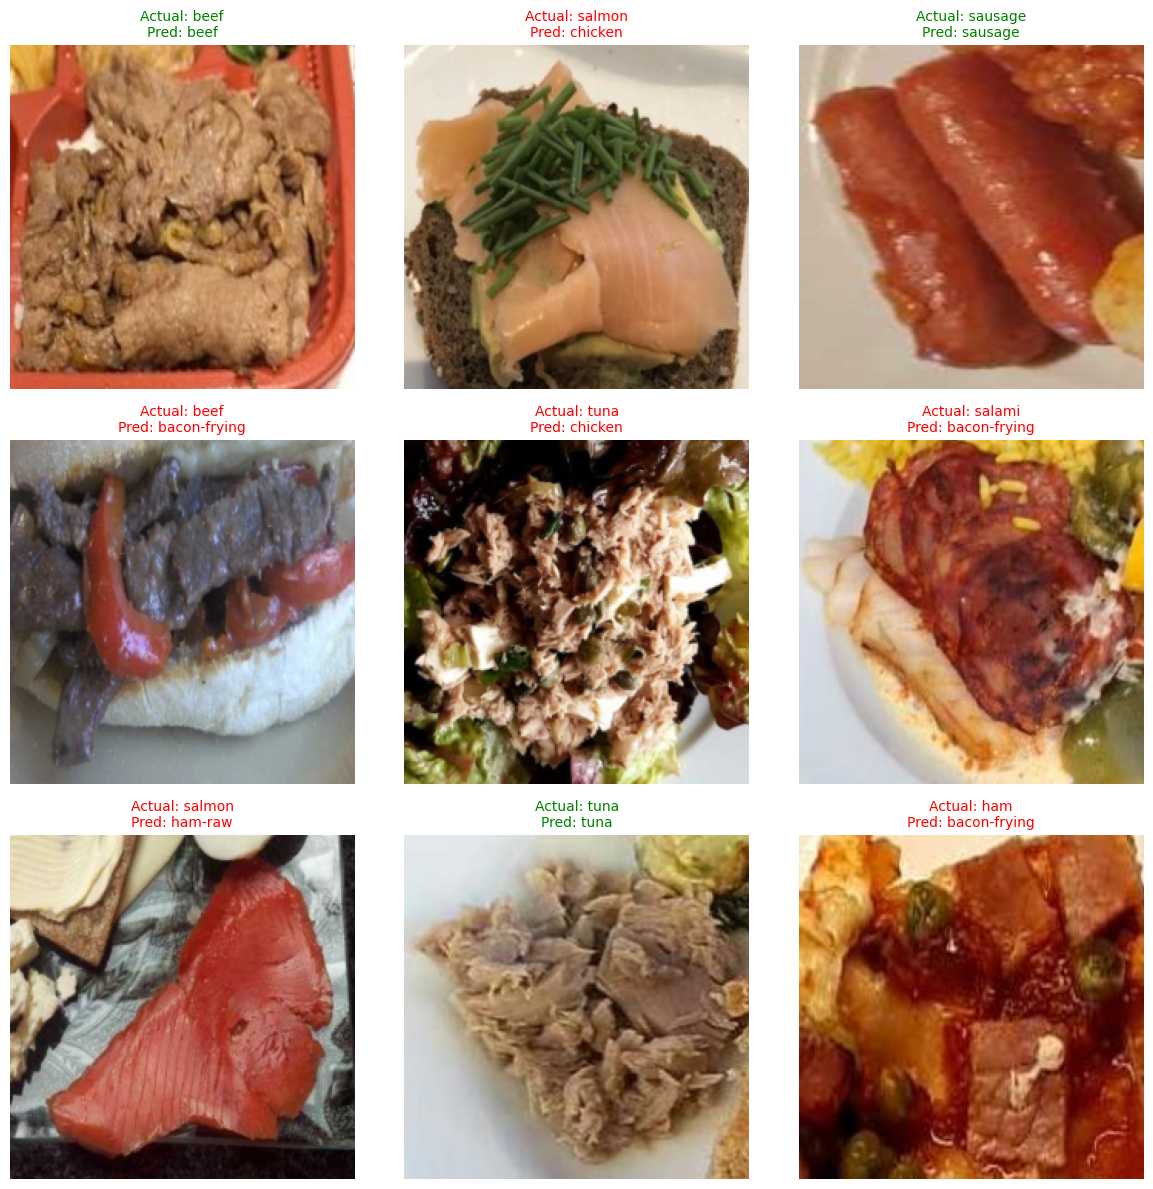

In [21]:
# 1. Load the trained model weights
try:
    model.load_state_dict(torch.load('model/classification_models/meat_customcnn.pth'))
    print("Model weights loaded successfully.")
except:
    print("Could not load weights. Ensure the model file exists and paths are correct.")


# 2. Run the visualization for 9 samples
visualize_inference_grid(
    model, 
    val_dataset, 
    num_samples=9, 
    group_name=GROUP_NAME, 
    device=device
)

In [32]:
import os
from ultralytics import YOLO

meat_model = YOLO("classification_models/YOLO/meat.pt")
meat_dir = "data/test_pics/meat/pexels-pixabay-60616.jpg"
# meat_dir = "data/test_pics/meat"

results = meat_model.predict(source=meat_dir, verbose=False)

Top 5 Predictions:
  chicken: 0.8273
  salmon: 0.1498
  beef: 0.0203
  sausage: 0.0025
  bacon-frying: 0.0001


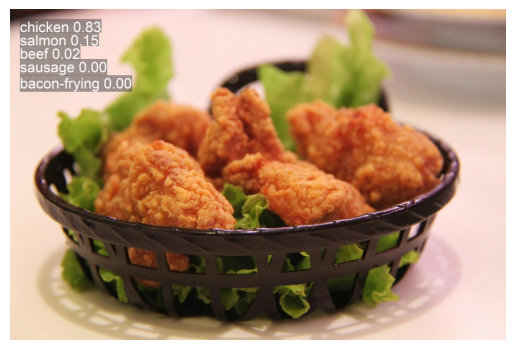

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

for result in results:
    names= result.names
    probs= result.probs
    top5cls = probs.top5
    top5probs = probs.top5conf
    
    print("Top 5 Predictions:")
    for cls, conf in zip(top5cls, top5probs):
        class_name = names[cls]
        confidence = conf.item()
        print(f"  {class_name}: {confidence:.4f}")
    im_array = result.plot()
    img_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
